<center>
    <h1 style="color: #2e7d32; font-size: 48px;">
                🌿 Plant Disease Detection 🌿
    </h1>
</center>


📋 **Business Objective Understanding**

🎯 1 .Objective:

📊 **2. Data Acquisition**


📂**2.1. Data Source**

**Source:** Kaggle

**Data Type:** Image dataset of plant leaves used for disease classification

The PlantVillage dataset is a collection of leaf
images categorized into different plant diseases
and healthy conditions. It contains labeled
images of crops like tomatoes, potatoes, and
peppers, helping in the identification of various
plant diseases


<p align="center">
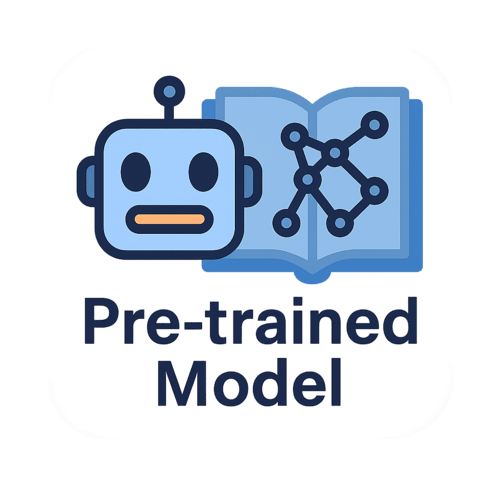
</p>

<font color='Green' size='5'><b> **Pre-trained model** </b></font>

A pre-trained model is a machine learning (ML) model that has been trained on a large dataset and can be fine-tuned for a specific task. Pre-trained models are often used as a starting point for developing ML models, as they provide a set of initial weights and biases that can be fine-tuned for a specific task.

<font color='brown' size='5'><b> **Inception v3** </b></font>

InceptionV3 is a convolutional neural network (CNN) architecture developed by Google, introduced in 2015 as an improved version of InceptionV1 (GoogLeNet). It is widely used for image classification tasks due to its balance between accuracy and computational efficiency. used for object recognition tasks.

Trained on ImageNet: Can recognize 1,000 categories of objects.



<font color='brown' size='5'><b> **Architecture InceptionV3** </b></font>



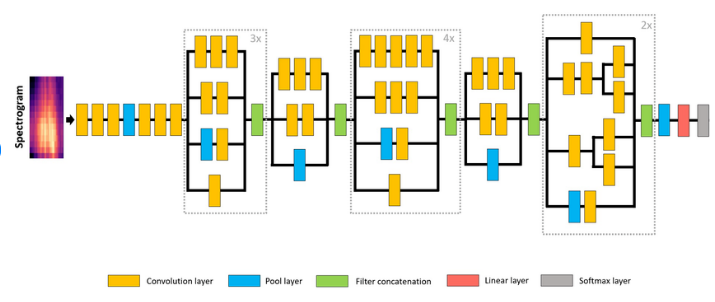

This  diagram shows a simplified architecture with:

Convolution layer → Local feature extraction.

Pool layer → Dimensionality reduction (e.g., max-pooling).

Filter concatenation → Feature fusion (similar to Inception modules).

Linear + Softmax → Classification.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import UnidentifiedImageError

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Vérifiez si le dossier existe
directory = '/content/drive/MyDrive/PlantVillage'
if os.path.isdir(directory):
    print("Le dossier existe !")
else:
    print("Le dossier n'existe pas.")

Le dossier existe !


In [4]:
# Chemin du dataset
data_dir = '/content/drive/MyDrive/PlantVillage'

# Détection du vrai dossier si sous-dossier unique
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
if len(subdirs) == 1 and subdirs[0] == "PlantVillage":
    data_dir = os.path.join(data_dir, "PlantVillage")

# Paramètres
img_size = (128, 128)
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(classes)
label_mapping = dict(zip(classes, encoded_labels))

def load_data(directory, target_size, label_mapping):
    images, labels = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            try:
                img = load_img(os.path.join(class_path, img_name), target_size=target_size)
                images.append(img_to_array(img) / 255.0)
                labels.append(label_mapping[class_name])
            except UnidentifiedImageError:
                print(f"Image non valide : {img_name}")
    return np.array(images), np.array(labels)

x_data, y_data = load_data(data_dir, img_size, label_mapping)
print(f"Images: {x_data.shape}, Labels: {y_data.shape}")

Images: (20638, 128, 128, 3), Labels: (20638,)




<font color='Green' size='5'><b> ***🖼️  ImageDataGenerator*** </b></font>

**ImageDataGenerator** ,Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating


Shear_range: counterclockwise shear angle in degrees

Zoom_range: zoom

Horizontal_flip: flip image horizontally

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_aug = ImageDataGenerator()

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,331,440 (85.19 MB)

 Trainable params: 528,656 (2.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

When compiling the model, we provide objective function (loss), optimization method (adam) and accuracy that we will follow.

For training, the 'fit()' function is used in the model with the following parameter:

train: training data

validation_data: validation set


verbose: to be able to see the outputs during the training (0-> does not show, 1-> does)

epoch: determines how many times the dataset will be trained by traversing the model

callbacks: An object that can perform actions at various stages of training .

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_aug.flow(x_train, y_train_cat, batch_size=32),
    epochs=30,
    validation_data=val_aug.flow(x_val, y_val_cat),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2502 - loss: 2.7314

516/516 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.2504 - loss: 2.7303 - val_accuracy: 0.5879 - val_loss: 1.3430
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4917 - loss: 1.6095

516/516 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.4917 - loss: 1.6094 - val_accuracy: 0.6492 - val_loss: 1.0989
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5647 - loss: 1.3539

516/516 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.5647 - loss: 1.3539 - val_accuracy: 0.6834 - val_loss: 0.9921
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5943 - loss: 1.2407

516/516 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.5943 - loss: 1.2407 - val_accuracy: 0.7028 - val_loss: 0.9266
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6206 - loss: 1.1744

516/516 ━━━━━━━━━━━━━━━━━━━━ 804s 2s/step - accuracy: 0.6206 - loss: 1.1744 - val_accuracy: 0.7057 - val_loss: 0.9078
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6414 - loss: 1.1022

516/516 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - accuracy: 0.6414 - loss: 1.1022 - val_accuracy: 0.7192 - val_loss: 0.8479
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6466 - loss: 1.0787

516/516 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.6466 - loss: 1.0787 - val_accuracy: 0.7311 - val_loss: 0.8222
Epoch 8/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6636 - loss: 1.0193

516/516 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.6636 - loss: 1.0193 - val_accuracy: 0.7304 - val_loss: 0.8109
Epoch 9/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6682 - loss: 1.0075

516/516 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.6682 - loss: 1.0075 - val_accuracy: 0.7367 - val_loss: 0.7969
Epoch 10/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.6699 - loss: 0.9909 - val_accuracy: 0.7343 - val_loss: 0.8045
Epoch 11/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6769 - loss: 0.9816

516/516 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.6770 - loss: 0.9815 - val_accuracy: 0.7498 - val_loss: 0.7713
Epoch 12/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6933 - loss: 0.9246

516/516 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.6933 - loss: 0.9246 - val_accuracy: 0.7553 - val_loss: 0.7415
Epoch 13/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6966 - loss: 0.9257

516/516 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.6966 - loss: 0.9257 - val_accuracy: 0.7568 - val_loss: 0.7397
Epoch 14/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6918 - loss: 0.9228

516/516 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.6918 - loss: 0.9228 - val_accuracy: 0.7599 - val_loss: 0.7189
Epoch 15/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7066 - loss: 0.8851

516/516 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.7066 - loss: 0.8851 - val_accuracy: 0.7648 - val_loss: 0.7155
Epoch 16/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7095 - loss: 0.8637

516/516 ━━━━━━━━━━━━━━━━━━━━ 775s 2s/step - accuracy: 0.7095 - loss: 0.8637 - val_accuracy: 0.7648 - val_loss: 0.7106
Epoch 17/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7085 - loss: 0.8667

516/516 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.7085 - loss: 0.8668 - val_accuracy: 0.7728 - val_loss: 0.6982
Epoch 18/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7147 - loss: 0.8618

516/516 ━━━━━━━━━━━━━━━━━━━━ 846s 2s/step - accuracy: 0.7147 - loss: 0.8618 - val_accuracy: 0.7742 - val_loss: 0.6937
Epoch 19/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7209 - loss: 0.8519

516/516 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.7209 - loss: 0.8519 - val_accuracy: 0.7810 - val_loss: 0.6723
Epoch 20/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.7210 - loss: 0.8439 - val_accuracy: 0.7747 - val_loss: 0.6798
Epoch 21/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.7183 - loss: 0.8522 - val_accuracy: 0.7791 - val_loss: 0.6731
Epoch 22/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7301 - loss: 0.8195

516/516 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.7301 - loss: 0.8195 - val_accuracy: 0.7844 - val_loss: 0.6543
Epoch 23/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 845s 2s/step - accuracy: 0.7287 - loss: 0.8144 - val_accuracy: 0.7812 - val_loss: 0.6575
Epoch 24/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7205 - loss: 0.8361

516/516 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.7206 - loss: 0.8360 - val_accuracy: 0.7866 - val_loss: 0.6526
Epoch 25/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7298 - loss: 0.8115

516/516 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.7298 - loss: 0.8115 - val_accuracy: 0.7902 - val_loss: 0.6430
Epoch 26/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.7342 - loss: 0.7990 - val_accuracy: 0.7827 - val_loss: 0.6606
Epoch 27/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7385 - loss: 0.7939

516/516 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.7385 - loss: 0.7939 - val_accuracy: 0.7934 - val_loss: 0.6396
Epoch 28/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.7425 - loss: 0.7743 - val_accuracy: 0.7934 - val_loss: 0.6407
Epoch 29/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.7344 - loss: 0.7921 - val_accuracy: 0.7890 - val_loss: 0.6420
Epoch 30/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7364 - loss: 0.7852

516/516 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.7364 - loss: 0.7853 - val_accuracy: 0.8004 - val_loss: 0.6257


In [ ]:
# Save model directly to Google Drive
model.save("/content/drive/MyDrive/plantVillage_inceptionv3.h5")

print("Model saved in Google Drive: MyDrive/plantVillage_inceptionv3.h5")

Model saved in Google Drive: MyDrive/plantVillage_inceptionv3.h5


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/plantVillage_inceptionv3.h5")  # adapte le chemin
print("Modèle chargé avec succès !")


Modèle chargé avec succès !


**📊 Evaluate the model on the validation data**

In [ ]:
val_loss, val_accuracy = model.evaluate(x_val, y_val_cat)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8049 - loss: 0.6246
Validation loss: 0.6257
Validation accuracy: 0.8004


In [ ]:
from sklearn.metrics import classification_report

# Liste des indices de classes dans le bon ordre
all_class_indices = list(label_mapping.values())

predictions = model.predict(x_val)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_val

# Affichage du rapport de classification en forçant toutes les classes
print(classification_report(
    true_classes,
    predicted_classes,
    labels=all_class_indices,
    target_names=list(label_mapping.keys())
))



                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.87      0.88      0.88       199
                     Pepper__bell___healthy       0.85      0.98      0.91       296
                               PlantVillage       0.00      0.00      0.00         0
                      Potato___Early_blight       0.89      0.91      0.90       200
                       Potato___Late_blight       0.79      0.78      0.78       200
                           Potato___healthy       0.85      0.57      0.68        30
                      Tomato_Bacterial_spot       0.75      0.87      0.80       426
                        Tomato_Early_blight       0.79      0.40      0.53       200
                         Tomato_Late_blight       0.79      0.78      0.79       382
                           Tomato_Leaf_Mold       0.75      0.63      0.69       190
                  Tomato_Septoria_leaf_spot       0.67      0.77

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

🧠 **Conclusion :**
Le modèle est globalement performant avec 80% de précision

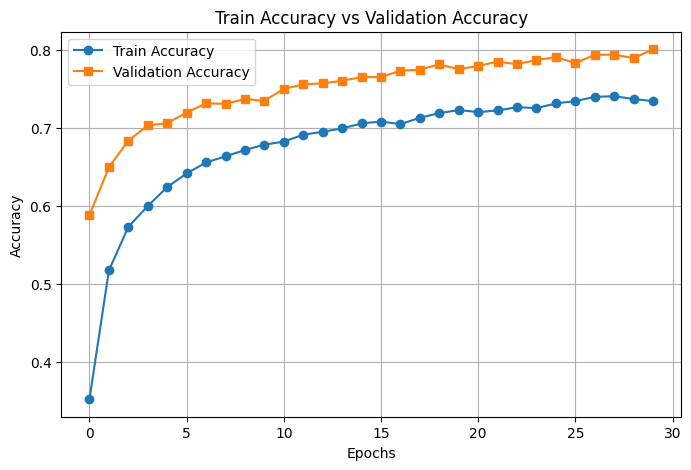

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')

# Formatting the graph
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


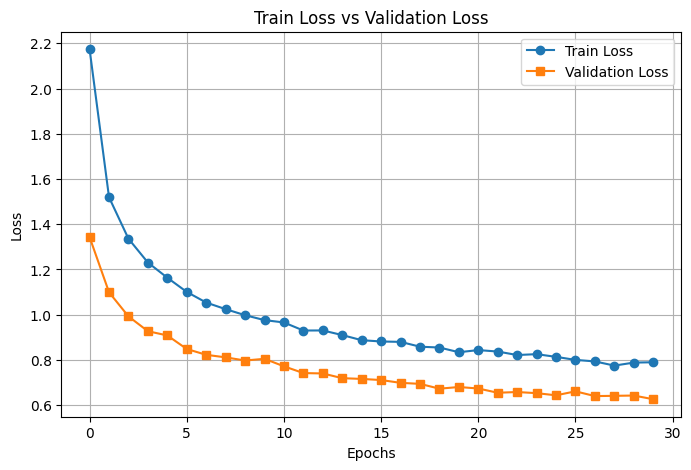

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


🧩 **Confusion Matrix**


The confusion matrix generated allows us to evaluate the performance of our plant disease classification model.
It is a table that compares:

The true classes (what it really was)

The predicted classes (what your model predicted)

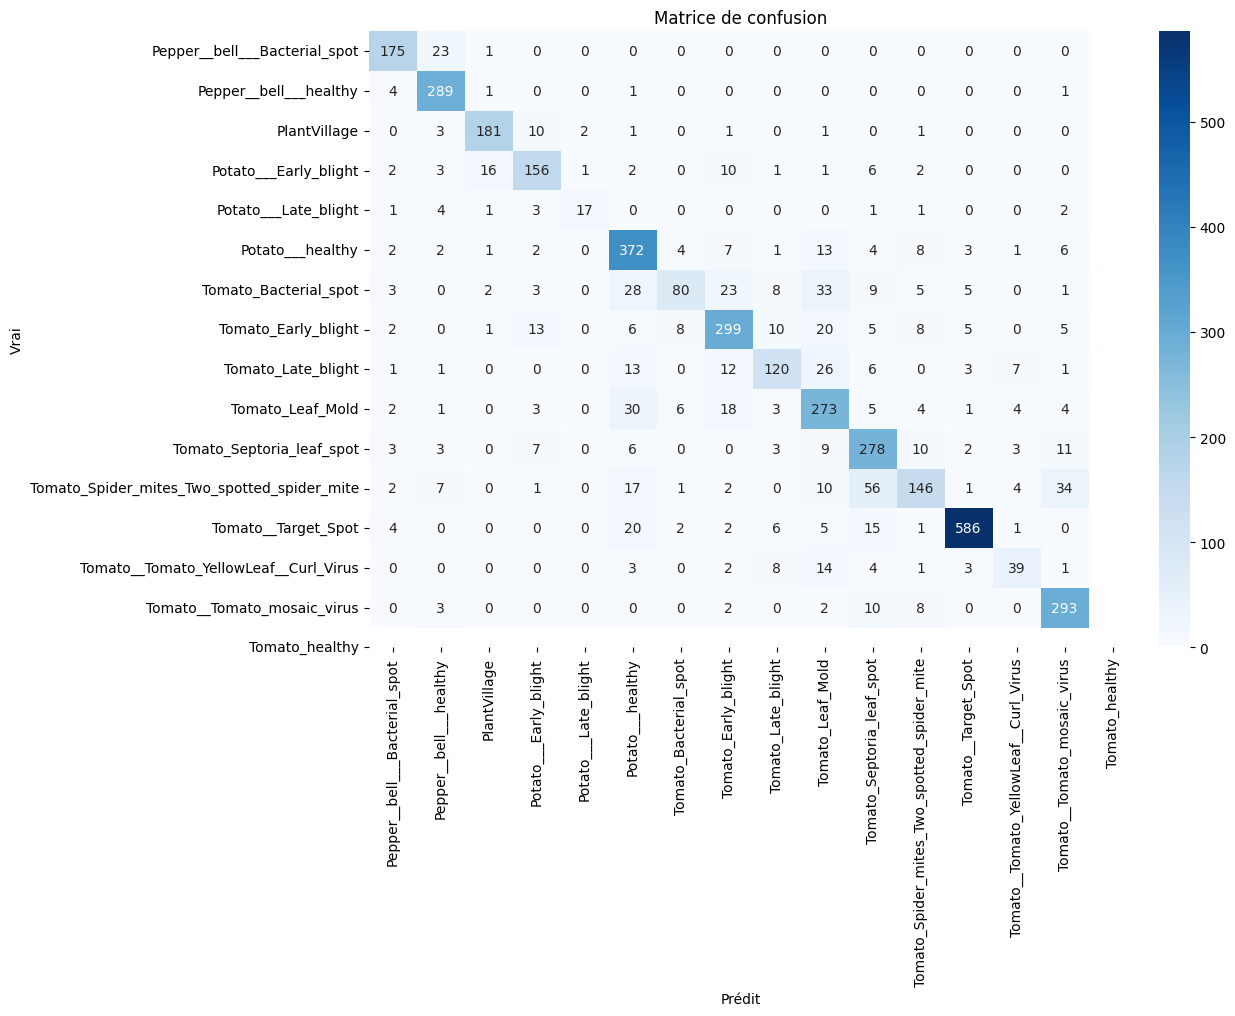

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()


* The rows represent the true classes (reality).

* The columns represent the classes predicted by your model.

* The diagonal (from top-left to bottom-right) = correct predictions ✅

* The values outside the diagonal = errors ❌





Overall, the model demonstrates a good generalization ability, with the majority of predictions located on the main diagonal, indicating that the classes were correctly identified.

However, some confusions can be observed between certain classes, notably between:

Pepper bell Bacterial spot and Pepper bell healthy

Certain tomato diseases such as Leaf Mold, Septoria Leaf Spot, and Spider mites

🖼️ **Test on New Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step

      🖼️ Résultat Prédiction
📁 Image         : imagePrédict.JPG
📌 Classe prédite: Tomato_Bacterial_spot
🔮 Confiance     : 70.83999633789062%



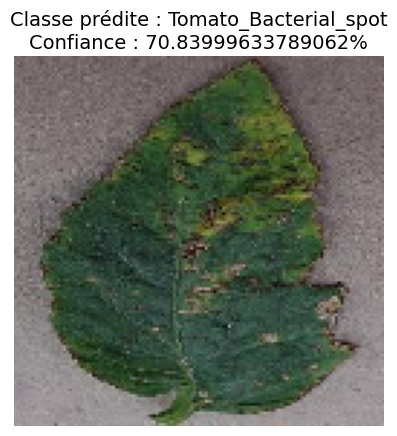

In [ ]:
# 🔍 Fonction de prédiction
def predict_image(image_path):
    if not os.path.exists(image_path):
        print(f"❌ Le fichier '{image_path}' n'existe pas.")
        return

    try:
        # Préparation de l'image
        img = load_img(image_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prédiction
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        confidence = round(np.max(prediction) * 100, 2)

        # Nom de la classe prédite
        class_name = next((k for k, v in label_mapping.items() if v == predicted_class_index), "Classe inconnue")

        # Affichage texte
        print("\n==============================")
        print("      🖼️ Résultat Prédiction")
        print("==============================")
        print(f"📁 Image         : {image_path}")
        print(f"📌 Classe prédite: {class_name}")
        print(f"🔮 Confiance     : {confidence}%")
        print("==============================\n")

        # Affichage de l'image avec titre
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Classe prédite : {class_name}\nConfiance : {confidence}%", fontsize=14)
        plt.show()

    except Exception as e:
        print(f"🚨 Une erreur est survenue : {str(e)}")

# 🧪 Exemple d'utilisation :
predict_image("imagePrédict.JPG")

<font color='brown' size='5'><b> **Vision Transformer (ViT) Model** </b></font>

A Vision Transformer (ViT) is a transformer-based model designed to handle vision processing tasks.

Vision Transformer (ViT) s'est imposé comme une alternative compétitive aux réseaux de neurones convolutifs (CNN), actuellement à la pointe de la technologie en vision par ordinateur et largement utilisés pour diverses tâches de reconnaissance d'images. Les modèles ViT surpassent de près de quatre fois les CNN actuels en termes d'efficacité et de précision de calcul.

 🔄 **Functioning of the Vision Transformer (ViT)**

 The Vision Transformer (ViT) works by first dividing the image into small patches (for example, 16×16), which are then flattened and projected into vectors using a linear layer. To preserve the spatial order of the patches, a positional encoding is added to each vector. These vectors, including a special [CLS] token used for classification, are then processed as a sequence by Transformer blocks using multi-head attention. At the output, the vector associated with the [CLS] token, which contains a global representation of the image, is passed through a dense layer to perform the final classification.

In [ ]:
!pip install vit-keras


In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

# Paramètres
input_shape = (224, 224, 3)
num_classes = 16

# Charger ViT depuis TensorFlow Hub
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
vit_layer = hub.KerasLayer(vit_url, trainable=False)

# Encapsuler l’appel à vit_layer dans une vraie fonction TensorFlow
@tf.function
def extract_features(images):
    return vit_layer(images)

# Construction du modèle
inputs = Input(shape=input_shape)
x = Lambda(lambda img: extract_features(img))(x)      # Appel propre à vit_layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,976 (785.06 KB)

 Trainable params: 200,976 (785.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paramètres
input_shape = (224, 224, 3)
num_classes = 16

# Supposons que x_data et y_data sont déjà chargés
# Split (déjà fait par toi, pas besoin de refaire)
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# One-hot encoding des labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Redimensionnement des images à la taille attendue par ViT
x_train_resized = tf.image.resize(x_train, (224, 224)).numpy()
x_val_resized = tf.image.resize(x_val, (224, 224)).numpy()

# Générateurs d'images avec augmentation + normalisation
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    rescale=1./255
)

val_aug = ImageDataGenerator(rescale=1./255)

# Générateurs à partir des tableaux NumPy
train_generator = train_aug.flow(x_train_resized, y_train_cat, batch_size=32)
val_generator = val_aug.flow(x_val_resized, y_val_cat, batch_size=32)

# Charger le modèle ViT depuis TensorFlow Hub
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
vit_layer = hub.KerasLayer(vit_url, trainable=False)

# Fonction de transformation via ViT
@tf.function
def extract_features(images):
    return vit_layer(images)

# Construction du modèle
inputs = Input(shape=input_shape)
x = Lambda(lambda img: img / 255.0)(inputs)
x = Lambda(lambda img: extract_features(img))(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

NameError: name 'x_data' is not defined

In [ ]:
model.summary()

In [ ]:
# Callback EarlyStopping et ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Entraînement du modèle avec augmentation de données
history = model.fit(
    train_aug.flow(x_train_resized, y_train_cat, batch_size=32),  # Flux d'entraînement avec augmentation
    epochs=30,  # Nombre d'époques
    validation_data=val_aug.flow(x_val_resized, y_val_cat, batch_size=32),  # Flux de validation
    callbacks=callbacks  # Callbacks définis ci-dessus
)


VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de VGG16
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,765,456 (60.14 MB)

 Trainable params: 1,050,768 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_aug.flow(x_train, y_train_cat, batch_size=32),
    epochs=20,
    validation_data=val_aug.flow(x_val, y_val_cat),
    callbacks=callbacks
)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6066 - loss: 1.1549

516/516 ━━━━━━━━━━━━━━━━━━━━ 84s 162ms/step - accuracy: 0.6066 - loss: 1.1549 - val_accuracy: 0.7873 - val_loss: 0.6447
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 144s 166ms/step - accuracy: 0.5999 - loss: 1.1465 - val_accuracy: 0.7810 - val_loss: 0.6926
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6227 - loss: 1.1033 - val_accuracy: 0.7842 - val_loss: 0.6486
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6332 - loss: 1.0760

516/516 ━━━━━━━━━━━━━━━━━━━━ 86s 167ms/step - accuracy: 0.6332 - loss: 1.0760 - val_accuracy: 0.7938 - val_loss: 0.6296
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6286 - loss: 1.0849

516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.6286 - loss: 1.0849 - val_accuracy: 0.7849 - val_loss: 0.6268
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.6325 - loss: 1.0547 - val_accuracy: 0.7919 - val_loss: 0.6270
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6291 - loss: 1.0608

516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.6291 - loss: 1.0608 - val_accuracy: 0.8154 - val_loss: 0.6003
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6413 - loss: 1.0474 - val_accuracy: 0.8069 - val_loss: 0.6025
Epoch 9/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6406 - loss: 1.0370

516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.6406 - loss: 1.0370 - val_accuracy: 0.8169 - val_loss: 0.5572
Epoch 10/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 142s 162ms/step - accuracy: 0.6488 - loss: 1.0303 - val_accuracy: 0.7992 - val_loss: 0.6005
Epoch 11/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.6538 - loss: 1.0022 - val_accuracy: 0.8108 - val_loss: 0.5651
Epoch 12/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 145s 167ms/step - accuracy: 0.6509 - loss: 1.0055 - val_accuracy: 0.7897 - val_loss: 0.5895
Epoch 13/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6488 - loss: 1.0182

516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.6488 - loss: 1.0182 - val_accuracy: 0.8198 - val_loss: 0.5558
Epoch 14/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.6501 - loss: 0.9863 - val_accuracy: 0.8135 - val_loss: 0.5569
Epoch 15/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6492 - loss: 1.0098

516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.6492 - loss: 1.0098 - val_accuracy: 0.8338 - val_loss: 0.4991
Epoch 16/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6611 - loss: 0.9845 - val_accuracy: 0.8113 - val_loss: 0.5673
Epoch 17/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6547 - loss: 0.9774 - val_accuracy: 0.7977 - val_loss: 0.5901
Epoch 18/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 86s 166ms/step - accuracy: 0.6584 - loss: 0.9819 - val_accuracy: 0.8132 - val_loss: 0.5613
Epoch 19/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.6674 - loss: 0.9701 - val_accuracy: 0.8273 - val_loss: 0.5372
Epoch 20/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.6691 - loss: 0.9595 - val_accuracy: 0.8224 - val_loss: 0.5316


In [ ]:
# Save model directly to Google Drive
model.save("/content/drive/MyDrive/plantVillage_VGG16.h5")

print("Model saved in Google Drive: MyDrive/plantVillage_VGG16.h5")

Model saved in Google Drive: MyDrive/plantVillage_VGG16.h5


In [8]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/plantVillage_VGG16.h5")
print("Modèle chargé avec succès !")

Modèle chargé avec succès !


**📊 Evaluate the model on the validation data**

In [9]:
val_loss, val_accuracy = model.evaluate(x_val, y_val_cat)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 848s 7s/step - accuracy: 0.8341 - loss: 0.4914
Validation loss: 0.4991
Validation accuracy: 0.8338


In [10]:
from sklearn.metrics import classification_report

# Liste des indices de classes dans le bon ordre
all_class_indices = list(label_mapping.values())

predictions = model.predict(x_val)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_val

# Affichage du rapport de classification en forçant toutes les classes
print(classification_report(
    true_classes,
    predicted_classes,
    labels=all_class_indices,
    target_names=list(label_mapping.keys())
))



129/129 ━━━━━━━━━━━━━━━━━━━━ 822s 6s/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.91      0.72      0.80       199
                     Pepper__bell___healthy       0.84      0.95      0.89       296
                               PlantVillage       0.00      0.00      0.00         0
                      Potato___Early_blight       0.94      0.88      0.91       200
                       Potato___Late_blight       0.73      0.90      0.80       200
                           Potato___healthy       1.00      0.07      0.12        30
                      Tomato_Bacterial_spot       0.89      0.92      0.91       426
                        Tomato_Early_blight       0.75      0.32      0.44       200
                         Tomato_Late_blight       0.82      0.75      0.78       382
                           Tomato_Leaf_Mold       0.73      0.78      0.75       190
                  Toma

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me